# Considerations regarding number of tokens and duration.

Deciding on an appropriate batch size can significantly impact the performance and stability of a system. An excessively small batch size can increase the overhead of API calls, leading to longer overall processing times. Conversely, an excessively large batch size can cause various issues, such as application timeouts.

How should we determine the appropriate batch size?

`openaivec` allows you to automatically determine the optimal batch size using a simple algorithm by specifying `batch_size=None`.
In this document, we will introduce the results of investigating the relationship between batch size and processing time using `BatchSizeSuggester` from `openaivec`.

And we will use the `gpt-5-nano` model for the experiments in this document.

In [1]:
import pandas as pd

from openaivec import pandas_ext
from openaivec.optimize import BatchSizeSuggester
from openaivec.proxy import AsyncBatchingMapProxy

pandas_ext.responses_model("gpt-5-nano")

This is a low-level API that you are unlikely to use. The `AsyncBachingMapProxy` has a parameter called `batch_size`, 
which, when set to `None`, allows the `BatchSizeSuggester` to automatically determine the batch size.

The fields of `BatchSizeSuggester` are hyperparameters for batch size optimization, and we will use them for performance investigation.

This configuration determines the batch size sequentially through the following steps:
1. The initial batch size is set to 10.
2. As records accumulate, it retrieves the most recent `sample_size=3` samples and calculates the average processing time.
3. If this average processing time is below `min_duration=60` seconds, it increases the batch size by `1 + step_ratio`.
4. Conversely, if the average processing time exceeds `max_duration=120` seconds, it decreases the batch size by `1 - step_ratio`.
5. This process is repeated to find the optimal batch size.

Actually, a duration of 60 to 180 seconds is quite long for application use cases, but here we set a longer duration for performance investigation.

For example, in systems like Apache Spark, various processes have timeouts set to several minutes.


In [ ]:
suggester = BatchSizeSuggester(
    current_batch_size=10,
    min_batch_size=10,
    min_duration=60,
    max_duration=180,
    step_ratio=0.2,
    sample_size=3
)

cache = AsyncBatchingMapProxy(
    batch_size=None,
    max_concurrency=8,
    show_progress=True,
    suggester=suggester
)

So this time we will repeat a simple task many times. Specifically, when given an employee ID, we will generate a random name.
We will execute this task while varying the `batch_size` and record the processing time for each batch.

In [ ]:
await pd.DataFrame({"id": list(range(10000))}).aio.assign(
    name=lambda df: df.aio.responses_with_cache(
        instructions="""
        For each employee ID, generate a random name in English, including both first and last names. 
        Just return the name without any additional text.
        """,
        temperature=None,
        cache=cache,
    )
)

`BatchSizeSuggester` records the processing time and exceptions for each batch as follows. Let's aggregate this data to investigate the relationship between batch size and processing time.

In [3]:
pd.DataFrame(suggester._history)

,duration,batch_size,executed_at,exception
0,6.529500,10,2025-08-13 08:19:38.219822+00:00,None
1,6.932385,10,2025-08-13 08:19:38.221014+00:00,None
2,7.282095,10,2025-08-13 08:19:38.221642+00:00,None
3,7.482255,10,2025-08-13 08:19:38.219217+00:00,None
4,8.440178,10,2025-08-13 08:19:38.094814+00:00,None
...,...,...,...,...
189,37.052500,151,2025-08-13 08:25:29.178854+00:00,None
190,54.033252,151,2025-08-13 08:25:19.301176+00:00,None
191,50.985222,181,2025-08-13 08:25:29.886626+00:00,None
192,63.045245,151,2025-08-13 08:25:25.487982+00:00,None


In [4]:
pd.DataFrame(suggester._history).to_csv("suggester_history.csv", index=False)


<Axes: title={'center': 'Batch Size vs Duration'}, xlabel='Batch Size', ylabel='Each Duration (seconds)'>

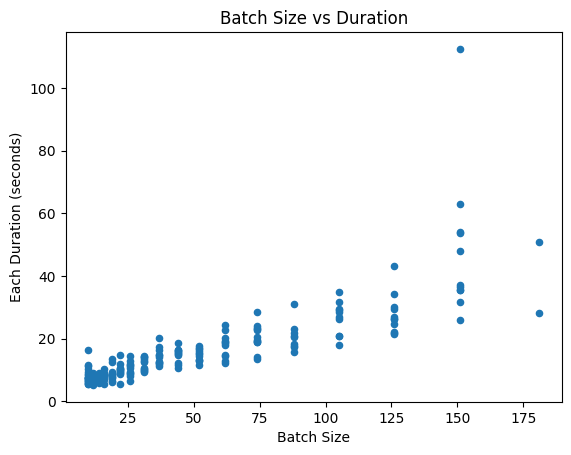

In [6]:
pd.read_csv("suggester_history.csv").plot(
    x="batch_size",
    y="duration",
    kind="scatter",
    title="Batch Size vs Duration",
    xlabel="Batch Size",
    ylabel="Each Duration (seconds)",
)

x-axis represents the batch size, and the y-axis represents the processing time for each batch. As expected, as the batch size increases, the processing time for each batch also increases.
However, it appears that the rate of increase in processing time becomes more gradual as the batch size increases. Let's verify this in the next figure.


<Axes: title={'center': 'Batch Size vs Unit Duration'}, xlabel='Batch Size', ylabel='Average Duration per Item (seconds)'>

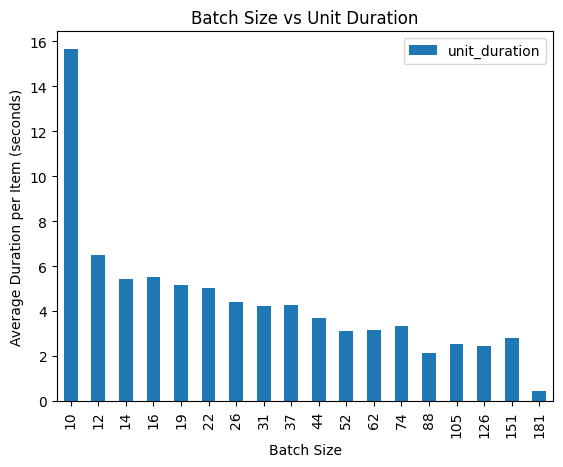

In [7]:
pd.read_csv("suggester_history.csv")[:-1].pipe(
    lambda df: df.groupby("batch_size").sum("duration").reset_index()
).assign(
    unit_duration=lambda df: df["duration"] / df["batch_size"]
).plot(
    x="batch_size",
    y="unit_duration",
    kind="bar",
    title="Batch Size vs Unit Duration",
    xlabel="Batch Size",
    ylabel="Average Duration per Item (seconds)",

)

This figure shows the relationship between batch size and average processing time per item.
Increasing the batch size gradually leads to larger processing times at first, as the OpenAI API's prompt cache benefits are not yet realized.
However, as the batch size increases, the average processing time gradually decreases. This is because the execution time of the batch includes overhead for API calls, so fewer calls result in shorter average processing times.

`openaivec` provides a feature to limit the processing time of each batch, allowing for stable data processing.